### Audio preprocessing references
1. https://www.kaggle.com/competitions/birdclef-2022/discussion/308497

### LibriSpeech dataset https://www.openslr.org/12
#### Description

In [10]:
import pandas as pd
import numpy as np
import librosa
import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import math
import torch
import IPython.display as ipd
import librosa.display

In [11]:
ipd.Audio("../data_manipulation/examples/kkk.flac")

### Get audio sampling rate and audio array value

In [12]:
y, sr = librosa.load("../data_manipulation/examples/kkk.flac")
# audio array, sample rate (discrete value in 1 audio)
y, sr

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 22050)

In [13]:
# convert to tensor and working torchaudio
tensor_y = torch.tensor(y).unsqueeze(0)
tensor_y.shape

torch.Size([1, 46085])

### Plotting audio wav form

In [14]:
def plot_waveform(waveform, sr, title="Waveform"):
    """ visualize wave form """
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.set_xlabel("time")
    axes.set_ylabel("amplitude")
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)

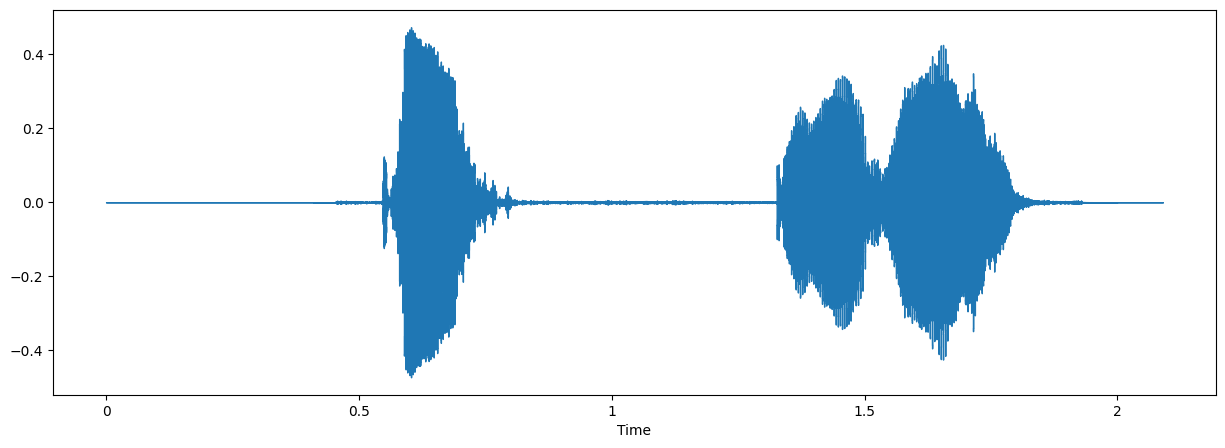

In [15]:
# plot_waveform(tensor_y, sr)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y=y, sr=sr)

### Get Mel Spectrogram with Torchaudio

In [16]:
def audio_transforms(array):
    """
    :param array: audio array get by torchaudio
    :return: log mel spectrogram
    """

    # define mel spec transform function
    F_mel = T.MelSpectrogram(
        sample_rate=22050,
        n_fft=640,
        win_length=640,
        hop_length=321,
        window_fn=eval("torch.hamming_window"),
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        n_mels=81,
        mel_scale="slaney",
    )

    # get mel spectrogram
    mel_spectrogram = F_mel(array)

    # log mel spectrogram
    # log_melspectrogram = F.amplitude_to_DB(mel_spectrogram, multiplier=10, amin=1e-10,
    #                                        db_multiplier=math.log10(max(1e-10, 1)))

    # adjust output
    # return log_melspectrogram.squeeze(0).transpose(0, 1).contiguous()
    return mel_spectrogram.squeeze(0)

In [17]:
def audio_transforms_logmel(array):
    """
    :param array: audio array get by torchaudio
    :return: log mel spectrogram
    """

    # define mel spec transform function
    F_mel = T.MelSpectrogram(
        sample_rate=22050,
        n_fft=640,
        win_length=640,
        hop_length=321,
        window_fn=eval("torch.hamming_window"),
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        n_mels=81,
        mel_scale="slaney",
    )

    # get mel spectrogram
    mel_spectrogram = F_mel(array)

    # log mel spectrogram
    log_melspectrogram = F.amplitude_to_DB(mel_spectrogram, multiplier=10, amin=1e-10,
                                           db_multiplier=math.log10(max(1e-10, 1)))

    # adjust output
    return log_melspectrogram.squeeze(0)

In [18]:
melspec = audio_transforms(tensor_y)
melspec[0][90]

tensor(0.0005)

### Define function to plot Mel Spectrogram

In [19]:
# Plot Mel spectrogram
def plot_melspectrogram(specgram, title=None, ylabel=None):
    """ visualize mel spectrogram && log mel spectrogram """
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Mel Spectrogram")
    axs.set_ylabel(ylabel=ylabel)
    axs.set_xlabel("frames")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

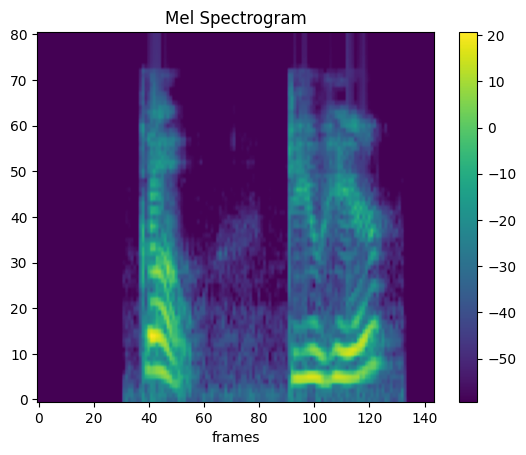

In [20]:
plot_melspectrogram(melspec)

## Processing audio Remove black space Trim and Zoom
### Other techniques:
1. Filtering
2. ***Segmentation***
3. Dynamic Range Compression
4. Pitch Correction

### Filtering
Used for filtering noise, it will lead to getting False at data point due to noise.
Types:
1. Low pass Filter
2. High pass Filter
3. Band pass Filter

#### References
1. https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7


### Why Trim?

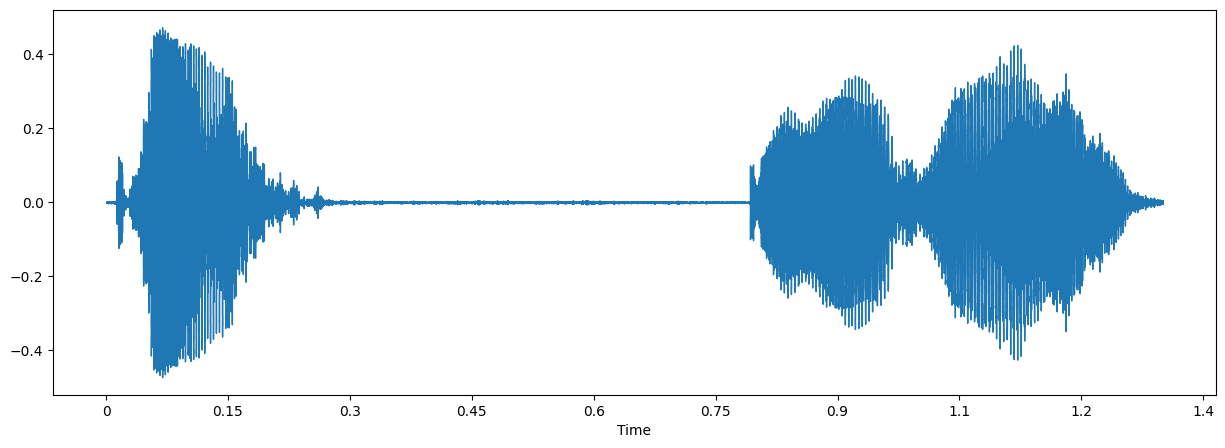

In [21]:
# Trim silence segment of audio
y_trimmed, _ = librosa.effects.trim(y, top_db=20)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y=y_trimmed, sr=sr)

In [22]:
ipd.Audio(data=y_trimmed, rate=22050)

In [23]:
tensor_ytrimmed = torch.tensor(y_trimmed).unsqueeze(0)
tensor_ytrimmed.shape

torch.Size([1, 28672])

In [24]:
mel_trimmed = audio_transforms(tensor_ytrimmed)
mel_trimmed

tensor([[3.3216e-04, 6.1805e-03, 4.8855e-03,  ..., 1.8237e-04, 1.0232e-04,
         7.9101e-04],
        [5.4911e-04, 7.2362e-03, 2.8101e-03,  ..., 3.2728e-04, 2.1710e-04,
         1.0415e-03],
        [4.3620e-04, 1.7310e-03, 8.5968e-04,  ..., 3.3564e-04, 4.5622e-04,
         7.3197e-04],
        ...,
        [4.2760e-09, 5.8034e-08, 4.0933e-09,  ..., 8.7922e-09, 9.1219e-10,
         1.8413e-09],
        [4.1839e-09, 5.7231e-08, 3.7011e-09,  ..., 8.6316e-09, 8.9627e-10,
         1.7698e-09],
        [4.1247e-09, 5.6753e-08, 3.4887e-09,  ..., 8.5387e-09, 8.8702e-10,
         1.7386e-09]])

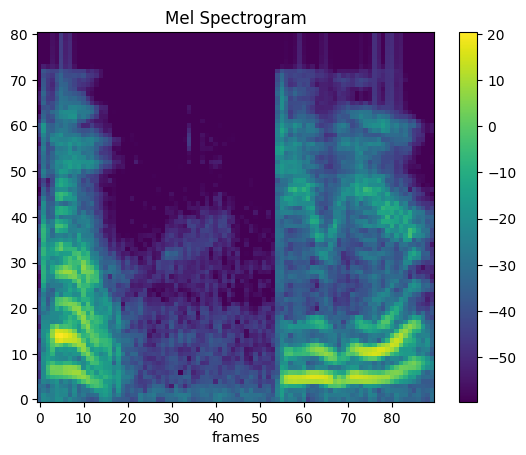

In [25]:
plot_melspectrogram(mel_trimmed)

### Get log mel with trimmed audio

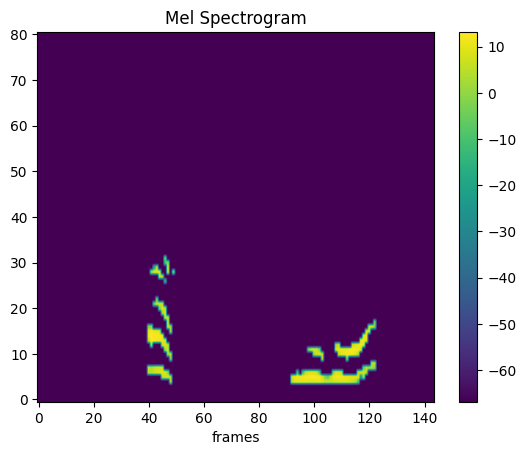

In [26]:
# get log mel with untrimmed audio
logmel_spec = audio_transforms_logmel(tensor_y)
plot_melspectrogram(logmel_spec)

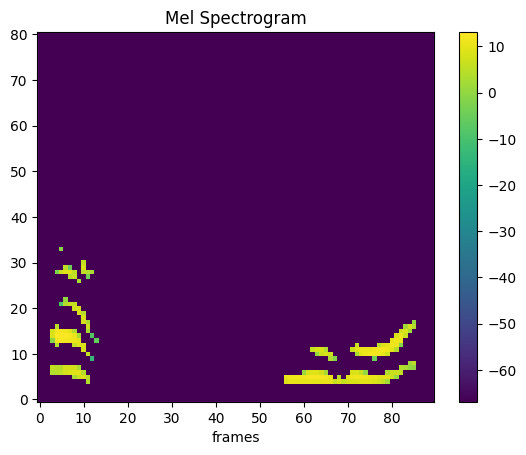

In [27]:
# get log mel with untrimmed audio
logmel_spec_trimmed = audio_transforms_logmel(tensor_ytrimmed)
plot_melspectrogram(logmel_spec_trimmed)